In [1]:
!pip install "jax[cuda12]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html

Looking in links: https://storage.googleapis.com/jax-releases/jax_cuda_releases.html

[notice] A new release of pip is available: 24.1.2 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [18]:
import jax
import jax.numpy as jnp
from jax import random, grad, value_and_grad
import jax.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
import gzip
import struct
from urllib import request
from tqdm import tqdm
from jax.tree_util import tree_map

# Model Definition

In [19]:
class CNNConfig:
    def __init__(self):
        self.input_shape = (1, 28, 28, 1)  # (batch_size, height, width, channels)
        self.conv1_filters = 32
        self.conv2_filters = 64
        self.kernel_size = 3
        self.dense_units = 256
        self.output_classes = 10

def conv2d(x, w, b, stride=1, padding='SAME'):
    """Convolutional layer implementation"""
    x = jax.lax.conv_general_dilated(
        lhs=x,
        rhs=w,
        window_strides=(stride, stride),
        padding=padding,
        dimension_numbers=('NHWC', 'OIHW', 'NHWC')
    )
    return x + b

def relu(x):
    """ReLU activation function"""
    return jnp.maximum(x, 0)

def max_pool(x, pool_size=2, stride=2, padding='VALID'):
    """Max pooling layer implementation"""
    return jax.lax.reduce_window(
        x,
        -jnp.inf,
        jax.lax.max,
        window_dimensions=(1, pool_size, pool_size, 1),
        window_strides=(1, stride, stride, 1),
        padding=padding
    )

def dense(x, w, b):
    """Fully connected layer implementation"""
    return jnp.dot(x, w) + b

def initialize_cnn_params(rng, config):
    """Initialize CNN model parameters with He initialization"""
    params = {}
    k1, k2, k3, k4 = random.split(rng, 4)
    
    # Conv1 layer parameters
    params['conv1_w'] = random.normal(k1, (
        config.conv1_filters, config.input_shape[-1], 
        config.kernel_size, 
        config.kernel_size)
    ) * jnp.sqrt(2/(config.kernel_size**2))
    params['conv1_b'] = jnp.zeros((config.conv1_filters,))
    
    # Simulate forward pass to get output shape after conv1 + pool
    x = jnp.zeros(config.input_shape)
    x = conv2d(x, params['conv1_w'], params['conv1_b'])
    x = relu(x)
    x = max_pool(x)
    
    # Conv2 layer parameters
    params['conv2_w'] = random.normal(k2, (config.conv2_filters, config.conv1_filters, 
                                          config.kernel_size, config.kernel_size)) * jnp.sqrt(2/(config.kernel_size**2))
    params['conv2_b'] = jnp.zeros((config.conv2_filters,))
    
    # Simulate forward pass to get output shape after conv2 + pool
    x = conv2d(x, params['conv2_w'], params['conv2_b'])
    x = relu(x)
    x = max_pool(x)
    
    # Calculate flattened dimensions for dense layer
    flatten_dim = x.shape[1] * x.shape[2] * x.shape[3]
    
    # Dense layers parameters
    params['dense1_w'] = random.normal(k3, (flatten_dim, config.dense_units)) * jnp.sqrt(2/flatten_dim)
    params['dense1_b'] = jnp.zeros((config.dense_units,))
    
    params['dense2_w'] = random.normal(k4, (config.dense_units, config.output_classes)) * jnp.sqrt(2/config.dense_units)
    params['dense2_b'] = jnp.zeros((config.output_classes,))
    
    return params


def forward(params, x):
    """Forward pass through the CNN model"""
    # First conv block
    x = conv2d(x, params['conv1_w'], params['conv1_b'])
    x = relu(x)
    x = max_pool(x)
    
    # Second conv block
    x = conv2d(x, params['conv2_w'], params['conv2_b'])
    x = relu(x)
    x = max_pool(x)
    
    # Flatten for dense layer
    x = x.reshape((x.shape[0], -1))
    
    # Dense layers
    x = dense(x, params['dense1_w'], params['dense1_b'])
    x = relu(x)
    x = dense(x, params['dense2_w'], params['dense2_b'])
    
    return x


# Optimizers

In [20]:
class SGDOptimizer:
    """Stochastic Gradient Descent optimizer implementation"""
    def __init__(self, learning_rate=0.01):
        self.learning_rate = learning_rate
    
    def init(self, params):
        """Initialize optimizer (no-op for SGD)"""
        # SGD doesn't need to maintain state
        pass
    
    def update(self, params, grads):
        """Update parameters using gradients"""
        return tree_map(lambda p, g: p - self.learning_rate * g, params, grads)
        

# New implementation of AdamOptimizer
class AdamOptimizer:
    """Adam optimizer implementation (compatible with JAX transformations)"""
    def __init__(self, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
    
    def init(self, params):
        """Initialize optimizer state"""
        # Return optimizer state instead of storing it as instance variables
        return {
            'm': tree_map(jnp.zeros_like, params),
            'v': tree_map(jnp.zeros_like, params),
            't': 0
        }
    
    def update(self, params, grads, opt_state):
        """Update parameters using gradients and optimizer state"""
        # Unpack optimizer state
        m, v, t = opt_state['m'], opt_state['v'], opt_state['t']
        
        # Increment timestep
        t = t + 1
        
        # Update biased first moment estimate
        m = tree_map(
            lambda m_i, g_i: self.beta1 * m_i + (1 - self.beta1) * g_i, 
            m, grads
        )
        
        # Update biased second raw moment estimate
        v = tree_map(
            lambda v_i, g_i: self.beta2 * v_i + (1 - self.beta2) * (g_i * g_i), 
            v, grads
        )
        
        # Compute bias-corrected first moment estimate
        m_hat = tree_map(
            lambda m_i: m_i / (1 - self.beta1 ** t), 
            m
        )
        
        # Compute bias-corrected second raw moment estimate
        v_hat = tree_map(
            lambda v_i: v_i / (1 - self.beta2 ** t), 
            v
        )
        
        # Update parameters
        updated_params = tree_map(
            lambda p, m_h, v_h: p - self.learning_rate * m_h / (jnp.sqrt(v_h) + self.epsilon),
            params, m_hat, v_hat
        )
        
        # Return updated parameters and optimizer state
        updated_opt_state = {'m': m, 'v': v, 't': t}
        return updated_params, updated_opt_state


# Metrics

In [21]:
def cross_entropy_loss(params, batch_images, batch_labels):
    """
    Compute cross entropy loss for a batch of images
    
    Args:
        params: Model parameters
        batch_images: Batch of input images (shape: [batch_size, height, width, channels])
        batch_labels: Batch of labels (shape: [batch_size])
        
    Returns:
        Average cross entropy loss for the batch
    """
    # Get model predictions
    logits = forward(params, batch_images)
    
    # Compute log probabilities
    log_probs = nn.log_softmax(logits)
    
    # Convert labels to one-hot encoding
    one_hot = jax.nn.one_hot(batch_labels, 10)
    
    # Compute cross entropy loss (negative log likelihood)
    return -jnp.sum(one_hot * log_probs) / batch_images.shape[0]

def compute_accuracy(params, batch_images, batch_labels):
    """
    Compute accuracy for a batch of images
    
    Args:
        params: Model parameters
        batch_images: Batch of input images
        batch_labels: Batch of labels
        
    Returns:
        Accuracy as a value between 0 and 1
    """
    # Get model predictions
    logits = forward(params, batch_images)
    
    # Get predicted class indices
    preds = jnp.argmax(logits, axis=-1)
    
    # Compute accuracy
    return jnp.mean(preds == batch_labels)

def precision_recall_f1(params, batch_images, batch_labels):
    """
    Compute precision, recall, and F1 score for a batch of images
    
    Args:
        params: Model parameters
        batch_images: Batch of input images
        batch_labels: Batch of labels
        
    Returns:
        Tuple of (precision, recall, f1) averaged across all classes
    """
    # Get model predictions
    logits = forward(params, batch_images)
    preds = jnp.argmax(logits, axis=-1)
    
    # Number of classes (assuming MNIST with 10 classes)
    num_classes = 10
    
    # Initialize lists for metrics
    precision_list, recall_list, f1_list = [], [], []
    
    # Compute metrics for each class
    for cls in range(num_classes):
        # True positives, false positives, false negatives
        tp = jnp.sum((preds == cls) & (batch_labels == cls))
        fp = jnp.sum((preds == cls) & (batch_labels != cls))
        fn = jnp.sum((preds != cls) & (batch_labels == cls))
        
        # Compute precision, recall, and F1 with small epsilon to avoid division by zero
        epsilon = 1e-8
        precision = tp / (tp + fp + epsilon)
        recall = tp / (tp + fn + epsilon)
        f1 = 2 * precision * recall / (precision + recall + epsilon)
        
        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1)
    
    # Return average metrics across all classes
    return jnp.mean(jnp.array(precision_list)), jnp.mean(jnp.array(recall_list)), jnp.mean(jnp.array(f1_list))


# Data Loading and Utilities

In [22]:
def download_file(url, filename):
    """Download a file if it doesn't exist"""
    if not os.path.exists(filename):
        print(f"Downloading {filename}...")
        request.urlretrieve(url, filename)
        print(f"Downloaded {filename}")

def load_mnist_raw():
    """
    Load MNIST dataset from raw files with error handling and alternate URLs
    
    Returns:
        Tuple of (train_images, train_labels, test_images, test_labels)
    """
    # Create data directory if it doesn't exist
    data_dir = "mnist_data"
    os.makedirs(data_dir, exist_ok=True)
    
    # Primary URLs for official MNIST dataset
    primary_urls = {
        "train_images": "http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz",
        "train_labels": "http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz",
        "test_images": "http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz",
        "test_labels": "http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz"
    }
    
    # Alternate URLs (mirrors) if primary fails
    alternate_urls = {
        "train_images": "https://storage.googleapis.com/cvdf-datasets/mnist/train-images-idx3-ubyte.gz",
        "train_labels": "https://storage.googleapis.com/cvdf-datasets/mnist/train-labels-idx1-ubyte.gz",
        "test_images": "https://storage.googleapis.com/cvdf-datasets/mnist/t10k-images-idx3-ubyte.gz",
        "test_labels": "https://storage.googleapis.com/cvdf-datasets/mnist/t10k-labels-idx1-ubyte.gz"
    }
    
    # File paths for downloaded data
    file_paths = {key: os.path.join(data_dir, f"{key}.gz") for key in primary_urls.keys()}
    
    # Try to download files from primary source, then fall back to alternate
    for key, url in primary_urls.items():
        if not os.path.exists(file_paths[key]):
            try:
                print(f"Downloading {key} from primary source...")
                request.urlretrieve(url, file_paths[key])
                print(f"Downloaded {key} successfully")
            except Exception as e:
                print(f"Failed to download from primary source: {e}")
                try:
                    print(f"Trying alternate source for {key}...")
                    alt_url = alternate_urls[key]
                    request.urlretrieve(alt_url, file_paths[key])
                    print(f"Downloaded {key} successfully from alternate source")
                except Exception as e2:
                    raise RuntimeError(f"Failed to download {key} from both sources. Errors: {e}, {e2}")
    
    # Parse MNIST files
    data = {}
    
    # Parse training images
    with gzip.open(file_paths["train_images"], 'rb') as f:
        magic, num, rows, cols = struct.unpack(">IIII", f.read(16))
        data["train_images"] = np.frombuffer(f.read(), dtype=np.uint8).reshape(num, rows, cols)
    
    # Parse training labels
    with gzip.open(file_paths["train_labels"], 'rb') as f:
        magic, num = struct.unpack(">II", f.read(8))
        data["train_labels"] = np.frombuffer(f.read(), dtype=np.uint8)
    
    # Parse test images
    with gzip.open(file_paths["test_images"], 'rb') as f:
        magic, num, rows, cols = struct.unpack(">IIII", f.read(16))
        data["test_images"] = np.frombuffer(f.read(), dtype=np.uint8).reshape(num, rows, cols)
    
    # Parse test labels
    with gzip.open(file_paths["test_labels"], 'rb') as f:
        magic, num = struct.unpack(">II", f.read(8))
        data["test_labels"] = np.frombuffer(f.read(), dtype=np.uint8)
    
    return (
        data["train_images"], 
        data["train_labels"], 
        data["test_images"], 
        data["test_labels"]
    )

def create_batches(images, labels, batch_size, shuffle=True):
    """Create batches of data for training/evaluation"""
    num_examples = len(images)
    indices = np.arange(num_examples)
    
    if shuffle:
        np.random.shuffle(indices)
    
    # Create list of batches
    batches = []
    for start_idx in range(0, num_examples, batch_size):
        end_idx = min(start_idx + batch_size, num_examples)
        batch_indices = indices[start_idx:end_idx]
        batches.append((images[batch_indices], labels[batch_indices]))
    
    return batches

def load_mnist(batch_size=128, seed=0):
    """
    Load and preprocess MNIST dataset
    
    Args:
        batch_size: Batch size for training/evaluation
        seed: Random seed for shuffling
        
    Returns:
        Tuple of (train_batches, test_batches)
    """
    # Set random seed for reproducibility
    np.random.seed(seed)
    
    # Check if preprocessed data exists in cache
    cache_file = "mnist_preprocessed.pkl"
    if os.path.exists(cache_file):
        print("Loading preprocessed MNIST data from cache...")
        with open(cache_file, 'rb') as f:
            train_images, train_labels, test_images, test_labels = pickle.load(f)
    else:
        print("Loading MNIST from raw files...")
        # Load raw data
        train_images, train_labels, test_images, test_labels = load_mnist_raw()
        
        # Preprocess images: reshape to include channel dimension and normalize to [0,1]
        train_images = train_images.reshape(-1, 28, 28, 1).astype(np.float32) / 255.0
        test_images = test_images.reshape(-1, 28, 28, 1).astype(np.float32) / 255.0
        
        # Cache the preprocessed data
        with open(cache_file, 'wb') as f:
            pickle.dump((train_images, train_labels, test_images, test_labels), f)
        print(f"Saved preprocessed data to {cache_file}")
    
    # Create training and test batches
    train_batches = create_batches(train_images, train_labels, batch_size, shuffle=True)
    test_batches = create_batches(test_images, test_labels, batch_size, shuffle=False)
    
    print(f"Created {len(train_batches)} training batches and {len(test_batches)} test batches")
    return train_batches, test_batches

def plot_training_curves(train_losses, test_losses, train_accuracies, test_accuracies):
    """Plot training and testing curves for loss and accuracy"""
    plt.figure(figsize=(10, 4))
    
    # Loss curve
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss Curve')
    
    # Accuracy curve
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(test_accuracies, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy Curve')
    
    plt.tight_layout()
    # plt.savefig('training_curves.png')
    plt.show()

def select_device(device_type="auto"):
    """
    Select appropriate device for training (CPU/GPU/TPU)
    
    Args:
        device_type: 'cpu', 'gpu', or 'auto' to automatically select
        
    Returns:
        Selected JAX device
    """
    if device_type == "cpu":
        device = jax.devices("cpu")[0]
    elif device_type == "gpu":
        try:
            gpus = jax.devices("gpu")
            if not gpus:
                raise RuntimeError("No GPU found, falling back to CPU")
            device = gpus[0]
        except RuntimeError:
            print("Warning: GPU requested but not available. Using CPU instead.")
            device = jax.devices("cpu")[0]
    else:  # Auto mode
        # Try to use GPU if available, otherwise use CPU
        try:
            gpus = jax.devices("gpu")
            if gpus:
                device = gpus[0]
                print("GPU detected, using GPU for training")
            else:
                device = jax.devices("cpu")[0]
                print("No GPU detected, using CPU for training")
        except:
            device = jax.devices("cpu")[0]
            print("Error detecting GPUs, falling back to CPU")
    
    print(f"✅ Using device: {device}")
    return device


# Training Functions

In [23]:
def save_model(params, path='best_model.pkl'):
    """
    Save model parameters to a file
    
    Args:
        params: Model parameters to save
        path: File path to save to
    """
    # Create directory if it doesn't exist
    os.makedirs(os.path.dirname(path) if os.path.dirname(path) else '.', exist_ok=True)
    
    with open(path, 'wb') as f:
        pickle.dump(params, f)
    print(f"✅ Model saved at {path}")

def load_model(path='best_model.pkl'):
    """
    Load model parameters from a file
    
    Args:
        path: File path to load from
        
    Returns:
        Loaded model parameters
    """
    if not os.path.exists(path):
        raise FileNotFoundError(f"Model file not found: {path}")
    
    with open(path, 'rb') as f:
        params = pickle.load(f)
    print(f"✅ Model loaded from {path}")
    return params

def get_learning_rate(initial_lr, epoch, decay_epochs=5, decay_factor=0.5):
    """
    Calculate learning rate with step decay
    
    Args:
        initial_lr: Initial learning rate
        epoch: Current epoch (1-based)
        decay_epochs: Number of epochs after which to decay the learning rate
        decay_factor: Factor by which to decay the learning rate
        
    Returns:
        Decayed learning rate
    """
    return initial_lr * (decay_factor ** (epoch // decay_epochs))

def evaluate(params, data_batches, device):
    """
    Evaluate model on a set of batches
    
    Args:
        params: Model parameters
        data_batches: List of (images, labels) batches
        device: JAX device to use for computation
        
    Returns:
        Dictionary of evaluation metrics
    """
    # Initialize metrics
    losses, accs, precs, recs, f1s = [], [], [], [], []
    
    # Evaluate on each batch
    for batch_images, batch_labels in data_batches:
        # Convert to JAX arrays and move to device
        batch_images = jax.device_put(jnp.array(batch_images), device)
        batch_labels = jax.device_put(jnp.array(batch_labels), device)
        
        # Compute metrics
        loss = cross_entropy_loss(params, batch_images, batch_labels)
        acc = compute_accuracy(params, batch_images, batch_labels)
        precision, recall, f1 = precision_recall_f1(params, batch_images, batch_labels)
        
        # Collect results
        losses.append(loss)
        accs.append(acc)
        precs.append(precision)
        recs.append(recall)
        f1s.append(f1)
    
    # Calculate average metrics
    return {
        'loss': jnp.mean(jnp.array(losses)),
        'accuracy': jnp.mean(jnp.array(accs)),
        'precision': jnp.mean(jnp.array(precs)),
        'recall': jnp.mean(jnp.array(recs)),
        'f1': jnp.mean(jnp.array(f1s)),
    }

# Main Training Function

In [28]:
def main():
    """Main training function"""
    print("\n=== CNN MNIST Classifier in JAX ===\n")
    
    # --- MODEL CONFIGURATION ---
    model_config = CNNConfig()
    
    # --- TRAINING HYPERPARAMETERS ---
    num_epochs = 10
    batch_size = 128
    initial_learning_rate = 0.001
    decay_epochs = 5
    decay_factor = 0.5
    checkpoint_path = 'best_model.pkl'
    seed = 0
    
    # --- DEVICE SETUP ---
    device = select_device("auto")
    
    # --- DATA LOADING ---
    print("\nLoading MNIST dataset...")
    train_batches, test_batches = load_mnist(batch_size=batch_size, seed=seed)
    
    # --- MODEL INITIALIZATION ---
    print("\nInitializing model parameters...")
    rng = random.PRNGKey(seed)
    rng = jax.device_put(rng, device)
    params = initialize_cnn_params(rng, model_config)
    
    # --- OPTIMIZER SETUP ---
    print("Setting up Adam optimizer...")
    optimizer = AdamOptimizer(learning_rate=initial_learning_rate)
    opt_state = optimizer.init(params)
    
    # --- METRICS TRACKING ---
    train_losses, train_accuracies = [], []
    test_losses, test_accuracies = [], []
    best_f1 = 0.0
    
    # --- UPDATE FUNCTION ---
    @jax.jit
    def update(params, batch_images, batch_labels, opt_state):
        """JIT-compiled update function for efficiency"""
        loss_value, grads = value_and_grad(cross_entropy_loss)(params, batch_images, batch_labels)
        updated_params, updated_opt_state = optimizer.update(params, grads, opt_state)
        return updated_params, updated_opt_state, loss_value
    
    # --- TRAINING LOOP ---
    print("\nStarting training...\n")
    for epoch in range(1, num_epochs + 1):
        epoch_losses = []
        
        # Update learning rate with decay
        current_lr = get_learning_rate(initial_learning_rate, epoch, decay_epochs, decay_factor)
        optimizer.learning_rate = current_lr
        
        print(f"Epoch {epoch}/{num_epochs} - Learning Rate: {current_lr:.6f}")
        
        # Training phase
        for batch_idx, (batch_images, batch_labels) in enumerate(tqdm(train_batches, desc="Training")):
            # Convert to JAX arrays and put on device
            batch_images_jax = jax.device_put(jnp.array(batch_images), device)
            batch_labels_jax = jax.device_put(jnp.array(batch_labels), device)
            
            # Update parameters and optimizer state
            params, opt_state, loss = update(params, batch_images_jax, batch_labels_jax, opt_state)
            epoch_losses.append(loss)
        
        # Calculate average training loss for the epoch
        train_loss = jnp.mean(jnp.array(epoch_losses))
        train_losses.append(train_loss)
        
        # Evaluate on training set (using subset for efficiency)
        print("Evaluating on training set...")
        train_eval_batches = train_batches[:len(train_batches)//5]  # Use 20% of training data for evaluation
        train_metrics = evaluate(params, train_eval_batches, device)
        train_accuracy = train_metrics['accuracy']
        train_accuracies.append(train_accuracy)
        
        # Evaluate on test set
        print("Evaluating on test set...")
        test_metrics = evaluate(params, test_batches, device)
        test_losses.append(test_metrics['loss'])
        test_accuracies.append(test_metrics['accuracy'])
        
        # Save model if improved
        if test_metrics['f1'] > best_f1:
            best_f1 = test_metrics['f1']
            save_model(params, checkpoint_path)
            print(f"✅ New best model saved (F1: {best_f1:.4f})")
        
        # Print epoch summary
        print(f"Epoch {epoch:02d} Summary:")
        print(f"  Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
        print(f"  Test Loss: {test_metrics['loss']:.4f}, Test Accuracy: {test_metrics['accuracy']:.4f}")
        print(f"  Test Precision: {test_metrics['precision']:.4f}, Test Recall: {test_metrics['recall']:.4f}, Test F1: {test_metrics['f1']:.4f}")
        print()
    
    # --- PLOT TRAINING CURVES ---
    print("\nPlotting training curves...")
    plot_training_curves(train_losses, test_losses, train_accuracies, test_accuracies)
    
    # --- FINAL EVALUATION ---
    print("\nLoading best model for final evaluation...")
    best_params = load_model(checkpoint_path)
    final_metrics = evaluate(best_params, test_batches, device)
    
    print("\n🏆 FINAL EVALUATION (Best Model):")
    print(f"  Test Loss: {final_metrics['loss']:.4f}")
    print(f"  Test Accuracy: {final_metrics['accuracy']:.4f}")
    print(f"  Test Precision: {final_metrics['precision']:.4f}")
    print(f"  Test Recall: {final_metrics['recall']:.4f}")
    print(f"  Test F1: {final_metrics['f1']:.4f}")


=== CNN MNIST Classifier in JAX ===

GPU detected, using GPU for training
✅ Using device: cuda:0

Loading MNIST dataset...
Loading preprocessed MNIST data from cache...
Created 469 training batches and 79 test batches

Initializing model parameters...
Setting up Adam optimizer...

Starting training...

Epoch 1/10 - Learning Rate: 0.001000


Training: 100%|██████████| 469/469 [00:18<00:00, 25.51it/s] 


Evaluating on training set...
Evaluating on test set...
✅ Model saved at best_model.pkl
✅ New best model saved (F1: 0.9763)
Epoch 01 Summary:
  Train Loss: 0.3660, Train Accuracy: 0.9790
  Test Loss: 0.0715, Test Accuracy: 0.9776
  Test Precision: 0.9777, Test Recall: 0.9774, Test F1: 0.9763

Epoch 2/10 - Learning Rate: 0.001000


Training: 100%|██████████| 469/469 [00:00<00:00, 875.23it/s]


Evaluating on training set...
Evaluating on test set...
✅ Model saved at best_model.pkl
✅ New best model saved (F1: 0.9823)
Epoch 02 Summary:
  Train Loss: 0.0575, Train Accuracy: 0.9868
  Test Loss: 0.0537, Test Accuracy: 0.9834
  Test Precision: 0.9834, Test Recall: 0.9832, Test F1: 0.9823

Epoch 3/10 - Learning Rate: 0.001000


Training: 100%|██████████| 469/469 [00:00<00:00, 870.30it/s]


Evaluating on training set...
Evaluating on test set...
✅ Model saved at best_model.pkl
✅ New best model saved (F1: 0.9853)
Epoch 03 Summary:
  Train Loss: 0.0365, Train Accuracy: 0.9916
  Test Loss: 0.0412, Test Accuracy: 0.9863
  Test Precision: 0.9859, Test Recall: 0.9861, Test F1: 0.9853

Epoch 4/10 - Learning Rate: 0.001000


Training: 100%|██████████| 469/469 [00:00<00:00, 884.48it/s]


Evaluating on training set...
Evaluating on test set...
✅ Model saved at best_model.pkl
✅ New best model saved (F1: 0.9869)
Epoch 04 Summary:
  Train Loss: 0.0248, Train Accuracy: 0.9932
  Test Loss: 0.0414, Test Accuracy: 0.9875
  Test Precision: 0.9873, Test Recall: 0.9877, Test F1: 0.9869

Epoch 5/10 - Learning Rate: 0.000500


Training: 100%|██████████| 469/469 [00:00<00:00, 889.04it/s]


Evaluating on training set...
Evaluating on test set...
✅ Model saved at best_model.pkl
✅ New best model saved (F1: 0.9884)
Epoch 05 Summary:
  Train Loss: 0.0178, Train Accuracy: 0.9947
  Test Loss: 0.0371, Test Accuracy: 0.9889
  Test Precision: 0.9890, Test Recall: 0.9890, Test F1: 0.9884

Epoch 6/10 - Learning Rate: 0.000500


Training: 100%|██████████| 469/469 [00:00<00:00, 885.38it/s]


Evaluating on training set...
Evaluating on test set...
Epoch 06 Summary:
  Train Loss: 0.0136, Train Accuracy: 0.9966
  Test Loss: 0.0395, Test Accuracy: 0.9878
  Test Precision: 0.9877, Test Recall: 0.9879, Test F1: 0.9871

Epoch 7/10 - Learning Rate: 0.000500


Training: 100%|██████████| 469/469 [00:00<00:00, 922.11it/s]


Evaluating on training set...
Evaluating on test set...
Epoch 07 Summary:
  Train Loss: 0.0105, Train Accuracy: 0.9970
  Test Loss: 0.0422, Test Accuracy: 0.9882
  Test Precision: 0.9881, Test Recall: 0.9883, Test F1: 0.9875

Epoch 8/10 - Learning Rate: 0.000500


Training: 100%|██████████| 469/469 [00:00<00:00, 968.25it/s]


Evaluating on training set...
Evaluating on test set...
✅ Model saved at best_model.pkl
✅ New best model saved (F1: 0.9899)
Epoch 08 Summary:
  Train Loss: 0.0070, Train Accuracy: 0.9976
  Test Loss: 0.0390, Test Accuracy: 0.9904
  Test Precision: 0.9904, Test Recall: 0.9905, Test F1: 0.9899

Epoch 9/10 - Learning Rate: 0.000500


Training: 100%|██████████| 469/469 [00:00<00:00, 883.52it/s]


Evaluating on training set...
Evaluating on test set...
Epoch 09 Summary:
  Train Loss: 0.0087, Train Accuracy: 0.9957
  Test Loss: 0.0449, Test Accuracy: 0.9883
  Test Precision: 0.9883, Test Recall: 0.9886, Test F1: 0.9878

Epoch 10/10 - Learning Rate: 0.000250


Training: 100%|██████████| 469/469 [00:00<00:00, 906.45it/s]


Evaluating on training set...
Evaluating on test set...
Epoch 10 Summary:
  Train Loss: 0.0066, Train Accuracy: 0.9976
  Test Loss: 0.0424, Test Accuracy: 0.9885
  Test Precision: 0.9886, Test Recall: 0.9888, Test F1: 0.9881


Plotting training curves...


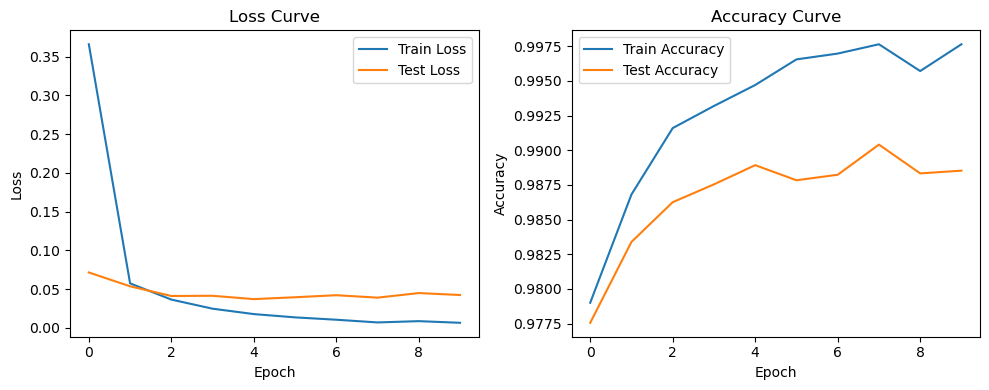


Loading best model for final evaluation...
✅ Model loaded from best_model.pkl

🏆 FINAL EVALUATION (Best Model):
  Test Loss: 0.0390
  Test Accuracy: 0.9904
  Test Precision: 0.9904
  Test Recall: 0.9905
  Test F1: 0.9899


In [29]:
main()